# Jack’s Car Rental problem

In [1]:
import numba
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numba import njit, prange
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

np.set_printoptions(suppress=True, linewidth=100)

Let
* $s_t^{(x)}$ be the number of cars at the end of day $t$,
* $\phi_t^{(x)}$ be the number of cars return to location $x$ at time $t$,
* $\varphi_t^{(x)}$ be the number of cars requested at location $x$ at time $t$, and
* $k_a \in \{-5, -4, \ldots, 4, 5\}$ be the number of cars moved from location $a$ to location $b$

## Location update
The state in location $a$ at end of day $t+1$, having moved $k_a$ cars overnight is
$$
\begin{aligned}
    s_{t+1}^{(a)'} &= s_t^{(a)} - k_a \\
    s_{t+1}^{(a)''} &= s_{t+1}^{(a)'} - \min\left(s_t^{(a)'}, \varphi_t^{(a)}\right) + \phi_t^{(a)}\\
    s_{t+1}^{(a)} &= \min\left( s_{t+1}^{(a)''}, 20 \right)
\end{aligned}
$$

In [3]:
# Discount rate
γ = 0.9
# Rate of request
λ_req_a, λ_req_b = 3, 4
# Rate of return
λ_ret_a, λ_ret_b = 3, 2

# Maximum number of cars allowed at any location
max_cars = 20
# Maximum number of cars that are allowed to be moved overnight
max_car_move = 5
# cost of moving two cars overnight
cost_move = 2.0

# MDP:
# timestep: days
# state: number of cars at each location at the end of the day
# actions: net number of cars moved between the two locations overnight

In [4]:
@njit
def approx_factorial(k):
    """
    Stirling's approximation to the factorial function
    """
    kf = 1
    for i in range(1, k+1):
        kf *= i
    return kf
    val = np.sqrt(2 * np.pi * k) * (k / np.e) ** k
    return val * (1 - (k == 0)) + 1 * (k == 0)


@njit
def poisson_pmf(k, λ):
    return λ ** k * np.exp(-λ) / approx_factorial(k)


@njit
def clip(a, a_min, a_max):
    return np.minimum(a_max, np.maximum(a, a_min))


@njit
def pr_transition_a(n_ret, n_req):
    """
    Probability of transition at location a
    is given by the probability of returns
    times the probability of requests
    """
    p_ret = poisson_pmf(n_ret,  λ_ret_a)
    p_req = poisson_pmf(n_req, λ_req_a)
    return p_ret * p_req


@njit
def pr_transition_b(n_ret, n_req):
    p_ret = poisson_pmf(n_ret, λ_ret_b)
    p_req = poisson_pmf(n_req, λ_req_b)
    return p_ret * p_req


@njit
def update_states(
    n_a, n_b, n_ret_a, n_ret_b, n_req_a, n_req_b, action
):
    """
    Compute new state given overnight actions
    and intraday movements
    """
    n_a_prime = n_a - action
    n_b_prime = n_b + action

    n_req_a = np.minimum(n_a_prime, n_req_a)
    n_req_b = np.minimum(n_b_prime, n_req_b)

    n_a_prime = clip(n_a_prime + n_ret_a - n_req_a, 0, max_cars)
    n_b_prime = clip(n_b_prime + n_ret_b - n_req_b, 0, max_cars)
    
    return (n_a_prime, n_b_prime), (n_req_a, n_req_b)


@njit
def weighted_term(
    n_a, n_b, n_ret_a, n_ret_b, n_req_a, n_req_b, action, value_function
):
    """
    Element of (proba x value) used to evaluate the value function of a policy
    
    Params
    ------
    n_a: number of cars at location a (start of day)
    n_ret_a: number of cars returns to location a (end of day)
    n_req_a: number of cars requested at location a (during day)
    
    n_b: number of cars at location b (start of day)
    n_ret_b: number of cars returned to location b (end of day)
    n_req_b: number of cars requested at location b
    
    action: number of cars moved from a to b overnight
    """
    pr_a = pr_transition_a(n_ret_a, n_req_a)
    pr_b = pr_transition_b(n_ret_b, n_req_b)
    
    
    (n_a_prime, n_b_prime), (n_req_a, n_req_b) = update_states(
        n_a, n_b, n_ret_a, n_ret_b, n_req_a, n_req_b, action
    )
    
    pr =  pr_a * pr_b
    val = 10.0 * (n_req_a + n_req_b) + γ * value_function[int(n_a_prime), int(n_b_prime)]
    return pr * val


@njit(parallel=True)
def action_value_function_entry(n_a, n_b, action, value_function):
    is_valid_state = (action <= n_a) and (-action <= n_b)

    if not is_valid_state:
        return 0
    
    expectation = 0.0
    for n_req_a in prange(max_cars):
        for n_req_b in prange(max_cars):
            for n_ret_a in prange(max_cars):
                for n_ret_b in prange(max_cars):
                    term = weighted_term(
                        n_a, n_b,
                        n_ret_a, n_ret_b,
                        n_req_a, n_req_b,
                        action, value_function
                    )
                    expectation += term
    return expectation - cost_move * np.abs(action)


@njit
def update_policy_entry(n_a, n_b, value_function, actions):
    max_action = np.nan
    max_action_value = -1e10
    for action in actions:
        action_value = action_value_function_entry(n_a, n_b, action, value_function)
        if action_value > max_action_value:
            max_action_value = action_value
            max_action = action
    return max_action


@njit(parallel=True)
def eval_value_function(states_a, states_b, policy, value_function):
    nstates_a = len(states_a)
    nstates_b = len(states_b)
    V = np.zeros((nstates_a, nstates_b))
    for ixa in prange(nstates_a):
        for ixb in prange(nstates_b):
            n_a = states_a[ixa]
            n_b = states_b[ixb]
            action = policy[n_a, n_b]
            
            v = action_value_function_entry(n_a, n_b, action, value_function)
            V[n_a, n_b] = v
    return V


@njit(parallel=True)
def update_policy(states_a, states_b, value_function, actions):
    nstates_a = len(states_a)
    nstates_b = len(states_b)
    
    new_policy = np.zeros((nstates_a, nstates_b))
    for ixa in prange(nstates_a):
        for ixb in prange(nstates_b):
            n_a = states_a[ixa]
            n_b = states_b[ixb]
            action_new = update_policy_entry(n_a, n_b, value_function, actions)
            new_policy[n_a, n_b] = action_new
    return new_policy

@njit
def policy_evaluate(states_a, states_b, policy, V, threshold=1.0, max_iter=50, eps=1e-6):
    delta = 0.0
    values_delta = []
    for i in range(max_iter):
        V_new = eval_value_function(states_a, states_b, policy, V)
        
        delta = np.max(np.abs(V_new - V))
        # delta = np.maximum(delta, diff)
        V = V_new
        values_delta.append(delta)
        
        if delta <= threshold:
            break
    
    values_delta = np.array(values_delta)
    return V, values_delta

In [5]:
actions = np.arange(-5, 6)
states = np.arange(max_cars + 1)
V = np.zeros((max_cars + 1, max_cars + 1))
policy = np.zeros((max_cars + 1, max_cars + 1)).astype(int)

In [6]:
%%time
policy_stable = False
i = 0
policies_hist = []
while not policy_stable:
    print(f"Num its: {i:02}", end="\r")
    V, values_delta = policy_evaluate(states, states, policy, V, max_iter=40)
    policy_new = update_policy(states, states, V, actions)
    if (policy_new == policy).all():
        policy_stable = True
    
    policy = policy_new
    policies_hist.append(policy)
    i += 1

CPU times: user 23min 32s, sys: 17 s, total: 23min 49s
Wall time: 23.9 s


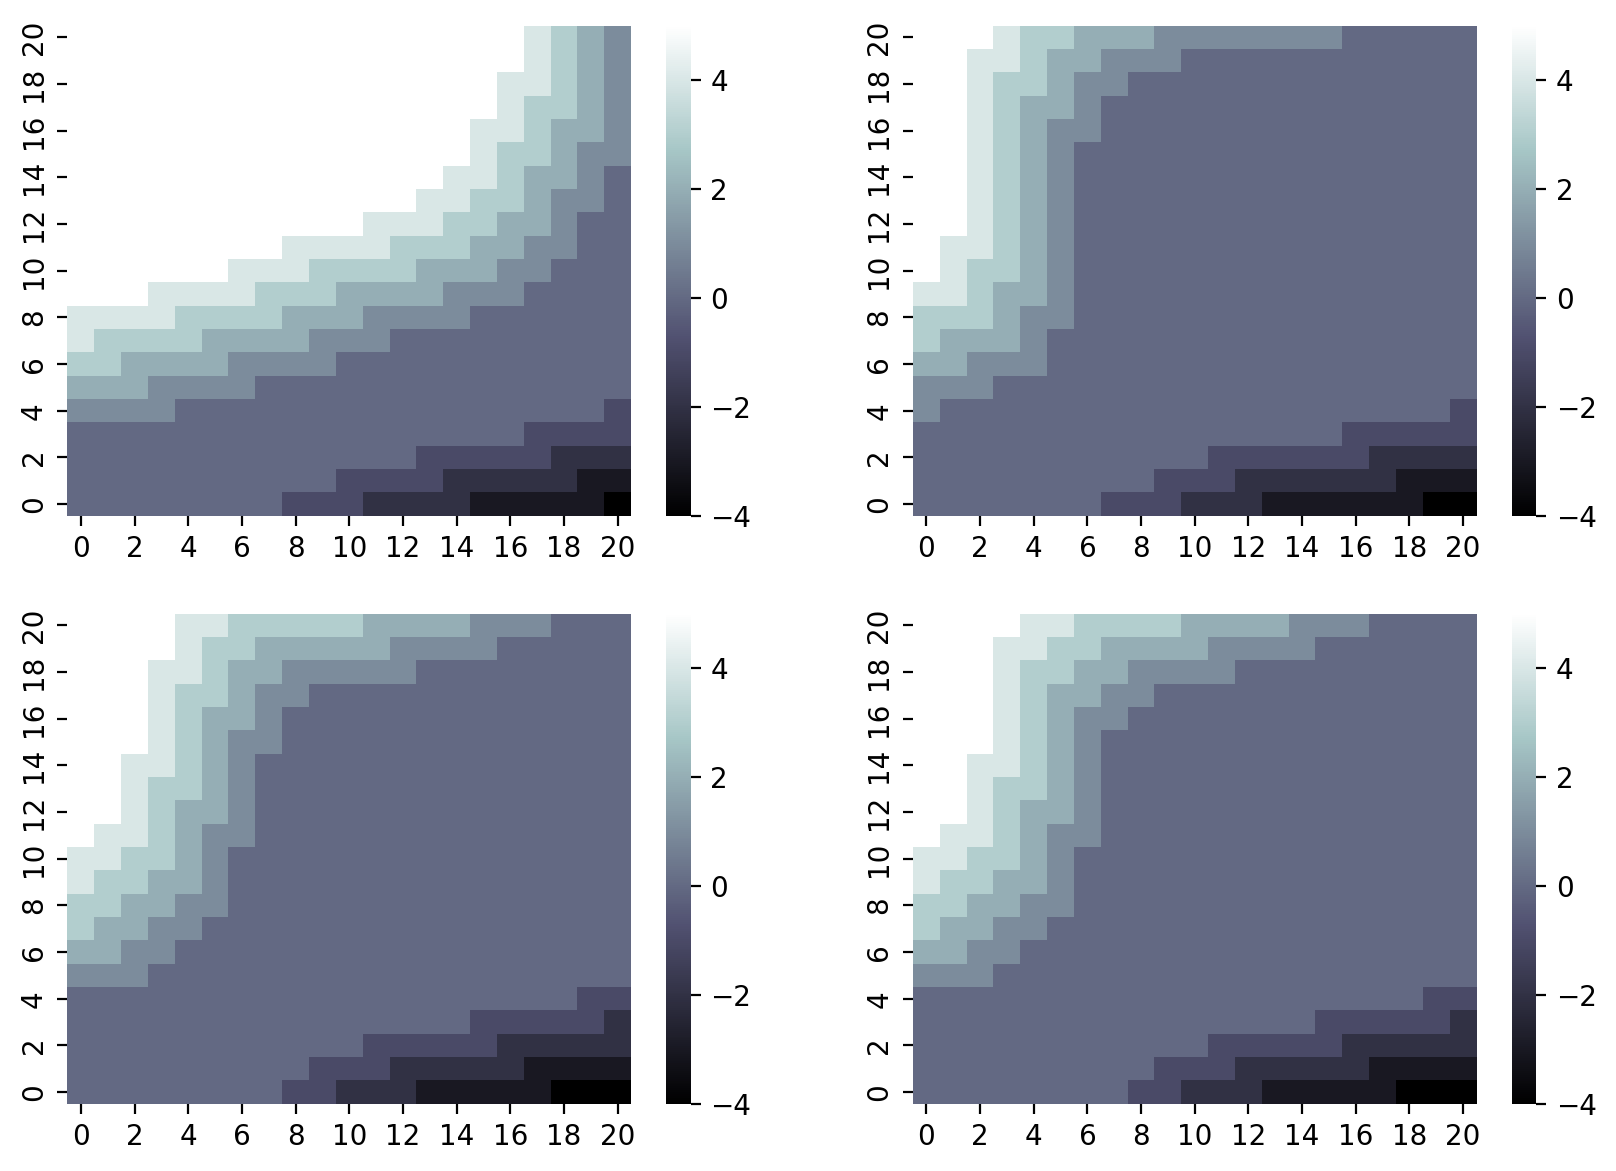

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
for axi, policy_i in zip(ax.ravel(), policies_hist):
    sns.heatmap(policy_i, ax=axi, cbar=True, cmap="bone")
    axi.invert_yaxis()

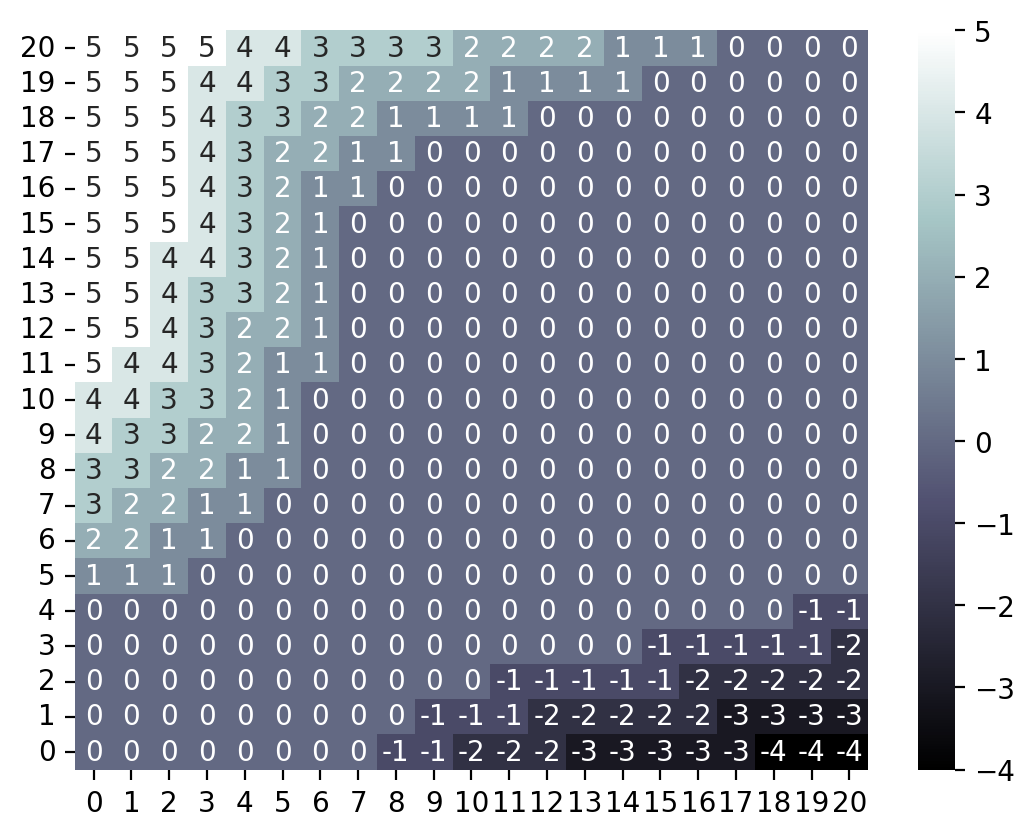

In [8]:
fig, ax = plt.subplots()
sns.heatmap(policy, cmap="bone", ax=ax, annot=True)
ax.invert_yaxis()

## Metric plots

In [9]:
prv = numba.vectorize([numba.float64(numba.int64, numba.int64)], target="parallel")(pr_transition_a)

0.9999999999764192

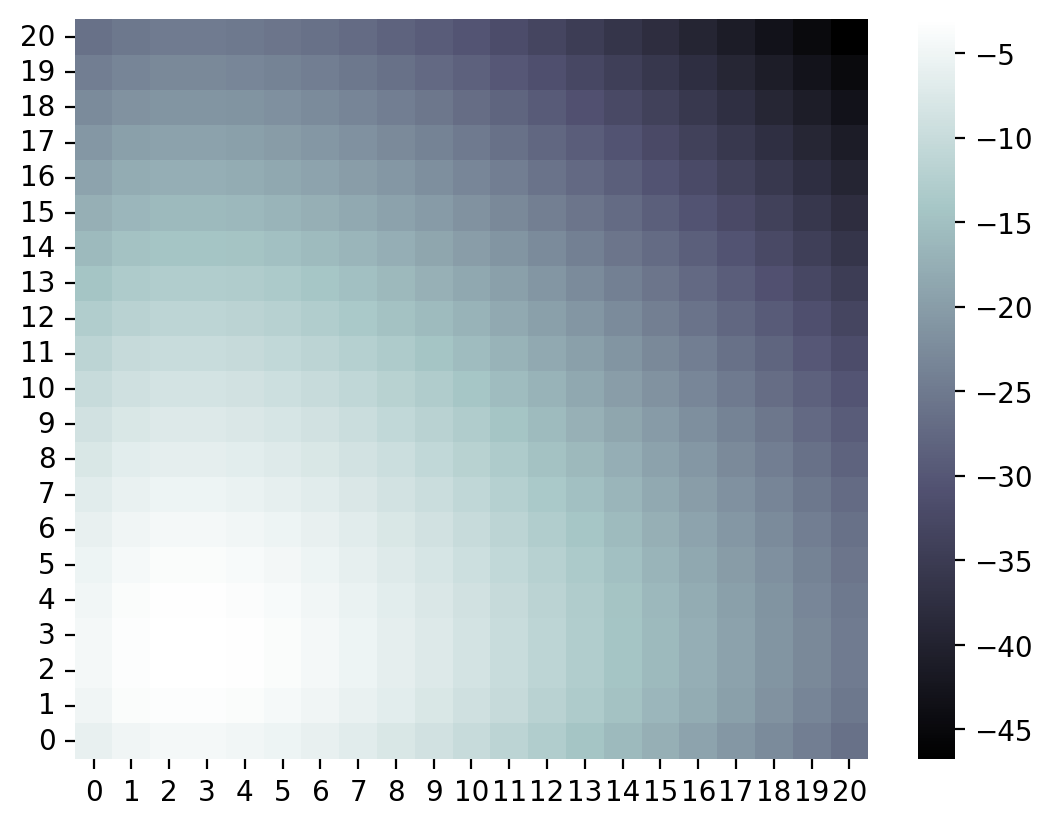

In [10]:
fig, ax = plt.subplots()
Pr = prv(states[:, None], states[None, :])
sns.heatmap(np.log(Pr), ax=ax, cmap="bone")
ax.invert_yaxis()
Pr.sum()